In [1]:
import numpy as np
from typing import List, Tuple
from os import path, getcwd
import matplotlib.pyplot as plt
import random

(a) Implement a variant of this algorithm based on memetic algorithms (MAs). Use
the 2-opt algorithm as local search technique in the memetic algorithm. The
2-opt algorithm tries to swap all pairs of cities to see if this improves the length
of the tour (see, e.g. https://en.wikipedia.org/wiki/2-opt).

In [2]:
cities_path = path.join(getcwd(), "file-tsp.txt")
ulysses_path = path.join(getcwd(), "ulysses16.txt")

candidate: List[int]

def get_fitness_func(distance_map:np.ndarray):
    """Helper-Function: Create a fitness function based on a table of distances"""
    def calc_dist(city_a:int, city_b:int):
        """Helper-Function: Calculate distance between cities a and b"""
        # Get the coordinates of city x
        x_a, y_a = distance_map[city_a]
        x_b, y_b = distance_map[city_b]
        return abs(x_a-x_b)+abs(y_a-y_b)


    def eval_fitness(candidate: List[int]):  
        """Calculate the fitness of a candidate"""
        total_dist = 0
        for i in range(0, len(candidate)-1):
            total_dist += calc_dist(candidate[i], candidate[i+1])
        return 1/total_dist
    
    def get_travel_time(candidate: List[int]):
        total_dist = 0
        for i in range(0, len(candidate)-1):
            total_dist += calc_dist(candidate[i], candidate[i+1])
        return total_dist
    
    return eval_fitness, get_travel_time

def get_cities(path):
    return np.genfromtxt(path)

In [3]:
def order_for_search(x:List[int], cut_point1:int, cut_point2:int) -> List[int]:
    """
    HELPER-FUNCTION: Orders the phenotype around the crossover points in order to simplify the merging.
    """
    return np.concatenate((x[cut_point2:], x[0:cut_point2]))

def produce_offspring(search_dig:List[int], cut_seq:List[int], cut_points:Tuple[int,int], phen_length:int) -> List[int]:
    offspring = np.zeros(phen_length, dtype=int)
    p1, p2 = cut_points
    offspring[p1:p2] = cut_seq
    for i in range(p2, phen_length):
        for digit in search_dig:
            if not digit in offspring:
                offspring[i] = digit
                break
    for i in range(0, p1):
        for digit in search_dig:
            if not digit in offspring:
                offspring[i] = digit
                break
    return offspring

def crossover(candidate1:List[int], candidate2: List[int]) -> Tuple[List[int], List[int]]:
    cut_point1 = random.randint(0, len(candidate1)-1)
    cut_point2 = random.randint(cut_point1, len(candidate1))
    seq_1 = candidate1[cut_point1:cut_point2]
    seq_2 = candidate2[cut_point1:cut_point2]

    parent1_search_dig = order_for_search(candidate1, cut_point1, cut_point2)
    parent2_search_dig = order_for_search(candidate2, cut_point1, cut_point2)

    phen_length = len(candidate1)

    offspring_1 = produce_offspring(parent2_search_dig, seq_1, (cut_point1, cut_point2), phen_length)
    offspring_2 = produce_offspring(parent1_search_dig, seq_2, (cut_point1, cut_point2), phen_length)

    return (offspring_1, offspring_2)

crossover(np.array([3,5,7,2,1,6,4,8]), np.array([2,5,7,6,8,1,3,4]))

(array([5, 7, 8, 1, 3, 6, 4, 2]), array([5, 7, 2, 6, 4, 1, 3, 8]))

In [4]:
def mutate(candidate:List[int]) -> List[int]:
    pos1 = random.randint(0, len(candidate)-1)
    pos2 = random.randint(0, len(candidate)-1)
    while pos1 == pos2:
        pos2 = random.randint(0, len(candidate)-1)

    mutated = candidate.copy()
    mutated[pos1] = candidate[pos2]
    mutated[pos2] = candidate[pos1]

    return mutated

#mutate([5,8,7,2,1,6,3,4])

In [5]:
def init_population(size:int, chromosomes:int):
    population = np.zeros((size, chromosomes), dtype=int)
    val_range = np.arange(chromosomes)
    for i in range(size):
        np.random.shuffle(val_range)
        population[i] = val_range
    
    return population
        

In [6]:
def tournament_select(population:np.ndarray, eval_fitness):
    """Returns the index of the candidate with the highest fitness. Does binary tournament selection"""
    cand1 = random.randint(0, len(population)-1)
    cand2 = random.randint(0, len(population)-1)
    while cand1 == cand2:
        cand2 = random.randint(0, len(population)-1)
    if eval_fitness(population[cand1]) >= eval_fitness(population[cand2]):
        return cand1
    else:
        return cand2


In [7]:
def eval_population(pop:np.ndarray, calc_travel_time):
    """Returns (mean_fitness, max_fitness, min_fitness, best_candidate) of the population"""
    travel_times = []
    for individual in pop:
        travel_times.append(calc_travel_time(individual))
    return np.mean(travel_times), np.max(travel_times), np.min(travel_times), np.argmin(travel_times)

def prep_travel_map(candidate, map):
    print(candidate)
    x_coords, y_coords = [], []
    for x in candidate:
        x_coords.append(map[x][0])
        y_coords.append(map[x][1])
    return x_coords, y_coords
    

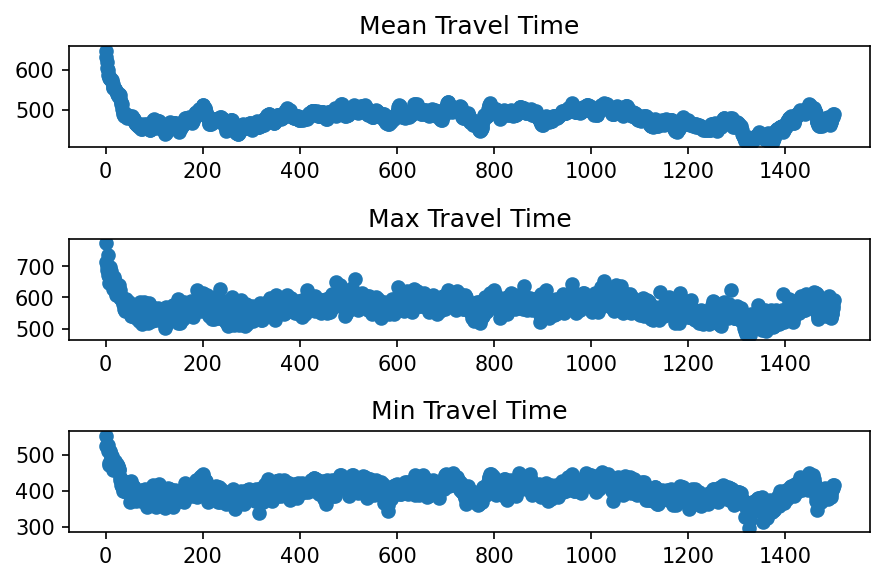

In [8]:
def simple_EA(city_dist:np.ndarray, pop_size:int, max_gen:int):
    # Define chromosome length of the phenotypes
    num_chromosomes = city_dist.shape[0]
    # Initialize the population of candidate solutions
    population = init_population(pop_size, num_chromosomes)
    # Create array to collect fitness statistics
    stats = []
    stats.append(eval_population(population, get_travel_time)[:-1])
    # probability for mutation
    p_m = 0.1
    # initial generation
    gen = 1
    while gen < max_gen:
        new_pop = np.zeros(population.shape, dtype=int)
        for i in range(0, pop_size, 2):
            parent1 = tournament_select(population, eval_fitness)
            parent2 = tournament_select(population, eval_fitness)
            offspring1, offspring2 = crossover(population[parent1], population[parent2])
            new_pop[i] = offspring1
            new_pop[i+1] = offspring2
            if random.random() < p_m: 
                new_pop[i] = mutate(new_pop[i])
            if random.random() < p_m:
                new_pop[i+1] = mutate(new_pop[i+1])
        
        stats.append(eval_population(new_pop, get_travel_time)[:-1])
        population = new_pop
        gen += 1
    fig, axs = plt.subplots(3, facecolor='w')
    axs[0].scatter(np.arange(max_gen), [stat[0] for stat in stats])
    axs[0].title.set_text("Mean Travel Time")
    axs[1].scatter(np.arange(max_gen), [stat[1] for stat in stats])
    axs[1].title.set_text("Max Travel Time")
    axs[2].scatter(np.arange(max_gen), [stat[2] for stat in stats])
    axs[2].title.set_text("Min Travel Time")
    fig.tight_layout()
    fig.set_dpi(150)
    return population
    

# Get Problem Setup
city_dist = get_cities(cities_path)
max_gens = 1500
pop_size = 10
# Create fitness function
eval_fitness, get_travel_time = get_fitness_func(city_dist)
population = simple_EA(city_dist, pop_size, max_gens)


[34 31 30 46 45  8 29 18 17 43 33 26  0 23 13 12  7 16 11 38 25 19 39 32
  2  5 24 28 35 27 22 15  9  6  4  3 37 14  1 21 20 41 10 40 44 36 42 47
 48 49]
13.3533 17.3524


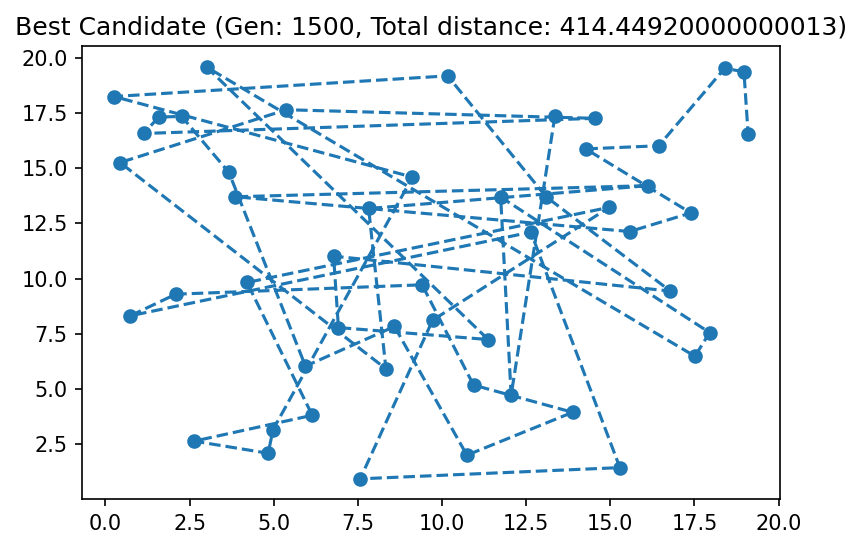

In [9]:
fig, axs = plt.subplots(facecolor='w')
_,_,_,best_idx = eval_population(population, get_travel_time)
best_candidate = population[best_idx]
best_travel_time = get_travel_time(best_candidate)
x_coords, y_coords = prep_travel_map(best_candidate, city_dist)
print(x_coords[0], y_coords[0])
axs.plot(x_coords, y_coords, marker='o', linestyle="--")
axs.title.set_text(f"Best Candidate (Gen: {max_gens}, Total distance: {best_travel_time})")
fig.set_dpi(150)

a) Implement a variant of this algorithm based on memetic algorithms (MAs). Use
the 2-opt algorithm as local search technique in the memetic algorithm. The
2-opt algorithm tries to swap all pairs of cities to see if this improves the length
of the tour (see, e.g. https://en.wikipedia.org/wiki/2-opt)

In [10]:
def two_opt_swap(phen:List[int], i:int, k:int) -> List[int]:
    new_route = np.zeros(len(phen), dtype=int)
    #1. take route[0] to route[i-1] and add them in order to new_route
    new_route[0:i] = phen[0:i]
    #2. take route[i] to route[k] and add them in reverse order to new_route
    new_route[i:k+1] = np.flip(phen[i:k+1])
    #3. take route[k+1] to end and add them in order to new_route
    new_route[k+1:] = phen[k+1:]
    return new_route

def two_opt_search(phen:List[int], eval_fitness) -> List[int]:
    fitness = eval_fitness(phen)
    found_better_phen = False
    while True:
        for i in range(len(phen)-1):
            for k in range(i+1, len(phen)):
                new_phen = two_opt_swap(phen, i, k)
                new_fitness = eval_fitness(new_phen)
                if new_fitness > fitness:
                    phen = new_phen
                    fitness = new_fitness
                    found_better_phen = True 
                    break
            if found_better_phen:
                found_better_phen = False
                break
        # End local search if no progress has been made
        if not found_better_phen:
            break
    return phen

(10, 50)


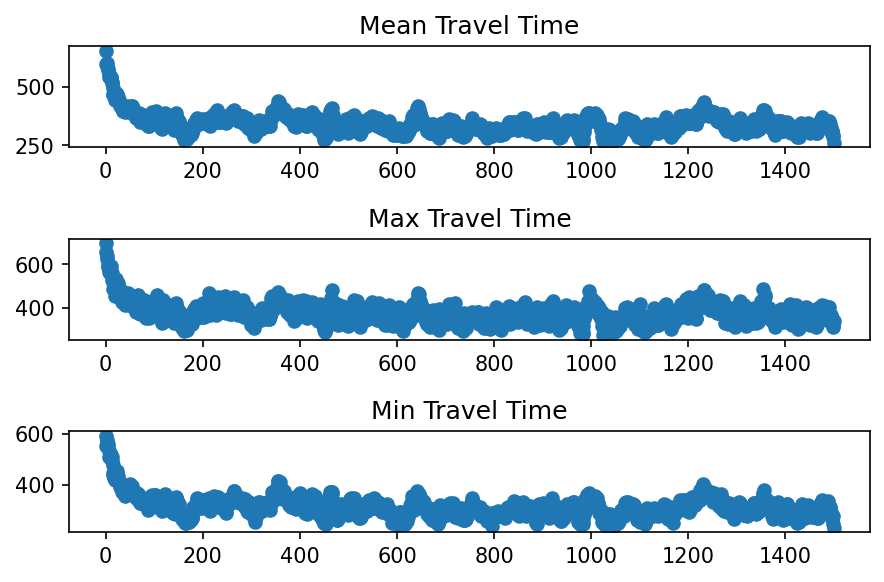

In [11]:
def two_opt_MA(city_dist:np.ndarray, pop_size:int, max_gen:int):
    # Define chromosome length of the phenotypes
    num_chromosomes = city_dist.shape[0]
    # Initialize the population of candidate solutions
    population = init_population(pop_size, num_chromosomes)
    print(population.shape)
    for i in range(population.shape[0]):
        population[i] = two_opt_search(population[i], eval_fitness)
    # Create array to collect fitness statistics
    stats = []
    stats.append(eval_population(population, get_travel_time)[:-1])
    # probability for mutation
    p_m = 0.1
    # initial generation
    gen = 1
    while gen < max_gen:
        new_pop = np.zeros(population.shape, dtype=int)
        for i in range(0, pop_size, 2):
            parent1 = tournament_select(population, eval_fitness)
            parent2 = tournament_select(population, eval_fitness)
            offspring1, offspring2 = crossover(population[parent1], population[parent2])
            new_pop[i] = offspring1
            new_pop[i+1] = offspring2
            if random.random() < p_m: 
                new_pop[i] = mutate(new_pop[i])
            if random.random() < p_m:
                new_pop[i+1] = mutate(new_pop[i+1])
            new_pop[i] = two_opt_search(new_pop[i], eval_fitness)
            new_pop[i+1] = two_opt_search(new_pop[i], eval_fitness)
        
        stats.append(eval_population(new_pop, get_travel_time)[:-1])
        population = new_pop
        gen += 1
    fig, axs = plt.subplots(3, facecolor='w')
    axs[0].scatter(np.arange(max_gen), [stat[0] for stat in stats])
    axs[0].title.set_text("Mean Travel Time")
    axs[1].scatter(np.arange(max_gen), [stat[1] for stat in stats])
    axs[1].title.set_text("Max Travel Time")
    axs[2].scatter(np.arange(max_gen), [stat[2] for stat in stats])
    axs[2].title.set_text("Min Travel Time")
    fig.tight_layout()
    fig.set_dpi(150)
    return population, stats

city_dist = get_cities(cities_path)
max_gens = 1500
pop_size = 10
# Create fitness function
eval_fitness, get_travel_time = get_fitness_func(city_dist)
population, stats = two_opt_MA(city_dist, pop_size, max_gens)

[33 34 26 47 48 41 44 46 45 43 49 42 36 37 40 38 39 35 28 25 22 18 16 12
  7  5  2  9 11 17 24 29 32 20 13 15 21 19 27 31 30 10 23 14  8  3  6  0
  1  4]
13.095 13.6956


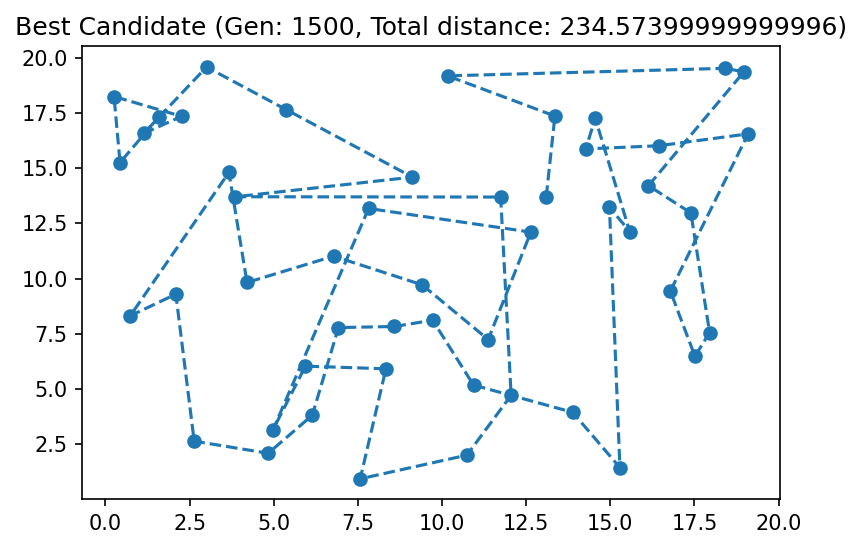

In [12]:
fig, axs = plt.subplots(facecolor='w')
_,_,_,best_idx = eval_population(population, get_travel_time)
best_candidate = population[best_idx]
best_travel_time = get_travel_time(best_candidate)
x_coords, y_coords = prep_travel_map(best_candidate, city_dist)
print(x_coords[0], y_coords[0])
axs.plot(x_coords, y_coords, marker='o', linestyle="--")
axs.title.set_text(f"Best Candidate (Gen: {max_gens}, Total distance: {best_travel_time})")
fig.set_dpi(150)

(b) Consider the TSP problem instance given in the file ‘file-tsp’. The file ‘file-
tsp’ contains a 50 ×2 matrix with the coordinates (xi,yi) for city i = 1,...,50.
Also, select a small instance at your choice from the ‘Symmetric Traveling Sales-
man Problem’ benchmark instances available at http://elib.zib.de/pub/
mp-testdata/tsp/tsplib/tsplib.html. Run the MA and EA 10 times on
these two problem instances

In [ ]:
# Get data
ulysses_map = get_cities(ulysses_path)
city_map = get_cities(cities_path)
pop_size = 10
max_gens = 1500

a_EA_stats = []
a_MA_stats = []
b_EA_stats = []
b_MA_stats = []
for i in range(10):
    population, stats = simple_EA(city_map, pop_size, max_gens)
    a_EA_stats.append(stats)
    population, stats = two_opt_MA(city_map, pop_size, max_gens)
    a_MA_stats.append(stats)
    population, stats = simple_EA(ulysses_map, pop_size, max_gens)
    b_EA_stats.append(stats)
    population, stats = two_opt_MA(ulysses_map, pop_size, max_gens)
    b_MA_stats.append(stats)

    


(c) For each algorithm (EA and MA), and for each problem instance, provide a
figure containing plots average and best fitness against the elapsed number of
iterations (1500 iterations) for all 10 runs

In [ ]:
# Plot comparison of EA and MA on Problem instance A
fig, axs = plt.subplots(2, facecolor='w')
axs[0].plot(np.arange(max_gens), [stat[0] for stat in a_EA_stats])
axs[0].plot(np.arange(max_gens), [stat[2] for stat in a_EA_stats])
axs[0].title.set_text("Mean Travel Time")
axs[1].plot(np.arange(max_gens), [stat[0] for stat in a_MA_stats])
axs[1].plot(np.arange(max_gens), [stat[2] for stat in a_MA_stats])
axs[1].title.set_text("Best Travel Time")
fig.tight_layout()
fig.set_dpi(150)

In [ ]:
# Plot comparison of EA and MA on Problem instance B
fig, axs = plt.subplots(2, facecolor='w')
axs[0].plot(np.arange(max_gens), [stat[0] for stat in b_EA_stats])
axs[0].plot(np.arange(max_gens), [stat[2] for stat in b_EA_stats])
axs[0].title.set_text("Mean Travel Time")
axs[1].plot(np.arange(max_gens), [stat[0] for stat in b_MA_stats])
axs[1].plot(np.arange(max_gens), [stat[2] for stat in b_MA_stats])
axs[1].title.set_text("Best Travel Time")
fig.tight_layout()
fig.set_dpi(150)